These produce a final .json file that can be used as an input in chemiscope to produce the final figures of the manuscript. 
The file can be already found in the downloaded folder.
However, if you want to run the notebook yourself, a new chemiscope file will be generated, along with new pcovr figures. 

In [1]:
%run ./modules.ipynb
%run ./data.ipynb

/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `Group` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member
/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `AutoGroup` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member
/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `ImportGroup` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member
/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `UpfFamily` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member


3DCD data analysis

In [6]:
npzfile = np.load(DATA_3DCD.soap_red, allow_pickle=True)

In [7]:
sns.set(style="white", palette="muted", color_codes=True)
my_c=colors.ListedColormap(["mediumblue", 'red'])
c= ["mediumblue", 'red']
sns.set_palette(sns.color_palette(c))

In [8]:
for k in npzfile.files:
    print(k)
my_frames=npzfile['my_frames']
idx=npzfile['idx']
magic=npzfile['magic']
X_raw=npzfile['X_raw']
coeff=npzfile['coeff']
len(my_frames)

idx
my_frames
magic
X_raw
coeff


840

COMPARING CLASSIFICATION MODELS. The function in ./modules.ipynb can be modified, as the support vector machine especially will take a long time with the complete data sets. 

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


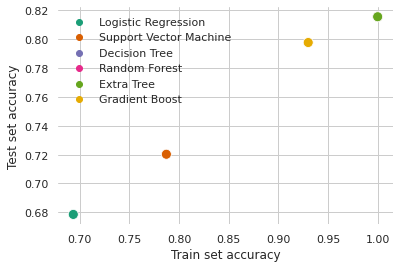

No handles with labels found to put in legend.


Classification models: ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Extra Tree', 'Gradient Boost']Train accuracies: [0.6934523809523809, 0.7872023809523809, 1.0, 1.0, 1.0, 0.9300595238095238]Test accuracies: [0.6785714285714286, 0.7202380952380952, 0.8154761904761905, 0.8154761904761905, 0.8154761904761905, 0.7976190476190477]


(<module 'seaborn' from '/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/__init__.py'>,
 None)

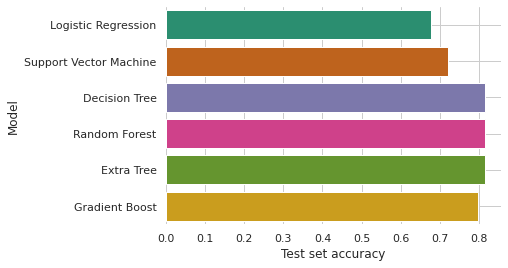

In [8]:
magic=[int(i) for i in magic]
magic=np.array(magic).reshape(-1,1)
y_magic=np.copy(magic.reshape(-1,1).ravel())

comp_classif(X_raw,y_magic) # prints out test set accuracy on all models

PCOVR ON CLASSIFICATION PROBABILITIES

In [9]:
X=np.copy(X_raw)
y_magic=np.copy(magic.reshape(-1,1))

In [10]:
i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
np.arange(X.shape[0]), X, y_magic, train_size=0.8
)
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
# Center total dataset
X = x_scaler.transform(X)
# Center training data
X_train = x_scaler.transform(X_train)
# Center training data
X_test = x_scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((672, 2000), (168, 2000), (672, 1), (168, 1))

In [11]:
clf = RandomForestClassifier(n_estimators=100, random_state=2)
clf.fit(X_train, y_train)
clf.predict(X_test)
print('Accuracy on test set:'+str(clf.score(X_test, y_test)))
p_random_for=clf.predict_proba(X)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy on test set:0.8095238095238095


(672, 2000) (168, 2000) (672, 1) (168, 1)
[[ -3.79735838]
 [  6.42228416]
 [  6.67891376]
 ...
 [-15.74101203]
 [-10.36842119]
 [ -0.14411092]] [0.50271208 0.10661955 0.06247827 0.05808674 0.02816263]


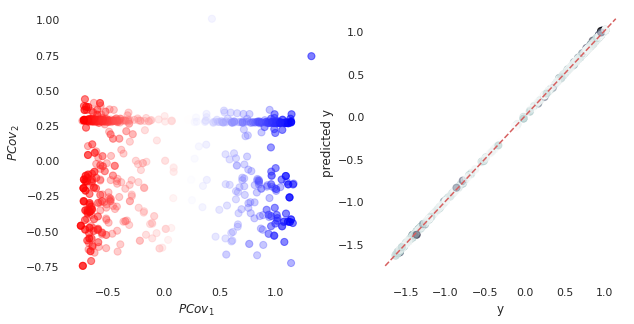

In [12]:
n_PC=5

y_tot=p_random_for[:,1].reshape(-1,1)
i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
np.arange(X.shape[0]), X, y_tot, train_size=0.8
)

x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
y_scaler = StandardFlexibleScaler(column_wise=True).fit(y_tot)

# Center total dataset
X = x_scaler.transform(X)
Y = y_scaler.transform(y_tot)

# Center training data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train)

# Center training data
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

pcovr = PCovR(mixing=0.5,
              n_components=n_PC)
pcovr.fit(X,Y)
T = pcovr.transform(X)
yp = pcovr.predict(X)
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))

ax1.scatter(T[:, 0], T[:, 1], s=50, alpha=0.3, c=p_random_for[:,1], cmap = 'bwr')
ax1.set_xlabel(r"$PCov_1$")
ax1.set_ylabel(r"$PCov_2$")
# ax1.set_xlim(-200,300)
# ax1.set_ylim(-200,400)

ax2.scatter(Y, yp, s=50, alpha=0.5, c=np.abs(Y - yp), cmap='bone_r')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'r--')
ax2.set_xlabel(r"y")
ax2.set_ylabel(r"predicted y")
sns.despine(left=True, bottom=True)

w_i_l=pcovr.pxt_
w_l_i=pcovr.pty_
w_i_p=pcovr.pxy_
var=pcovr.explained_variance_ 
sing=pcovr.singular_values_

print(w_i_p, var)

CORRELATIONS WITH SOAP VECTORS

In [32]:
upper_bound=0.2 #number above which the correlation is considered HIGH (maximum is 1)
lower_bound=0.1 #number below which the correlation is considered LOW (minimumis -1) 

col=range(0, len(X_raw))
df = pd.DataFrame(data=X_raw, index=col)
df[r'PC$_{1}$']=T[:,0]
corr=df.corrwith(df[r'PC$_{1}$'])
print(min(corr), max(corr), len(corr))
print(corr)
low_corr_soap=[]
high_corr_soap=[]
for i in range(len(corr)-1):
    if corr[i] <- lower_bound:
        low_corr_soap.append(i)
    if corr[i] > upper_bound:
        high_corr_soap.append(i)
    high_corr=[coeff[i] for i in high_corr_soap]
    low_corr=[coeff[i] for i in low_corr_soap]
print('high corr=' +str(high_corr)+'low corr=' +str(low_corr))

-0.14978506149783752 1.0 2001
0          -0.025784
1          -0.015752
2          -0.047896
3           0.092684
4          -0.091652
              ...   
1996        0.033147
1997        0.016161
1998        0.166490
1999       -0.060798
PC$_{1}$    1.000000
Length: 2001, dtype: float64
high corr=[]low corr=[array([12., 12.,  3.,  3.,  0.]), array([12., 12.,  0.,  2.,  0.]), array([12., 12.,  0.,  0.,  0.]), array([ 8., 23.,  2.,  0.,  0.]), array([12., 12.,  2.,  2.,  0.]), array([12., 12.,  0.,  3.,  0.]), array([12., 12.,  2.,  3.,  0.]), array([ 8., 12.,  2.,  3.,  0.]), array([9., 9., 2., 0., 0.]), array([ 8., 23.,  0.,  1.,  0.]), array([ 8., 22.,  0.,  1.,  0.]), array([ 8., 25.,  3.,  2.,  4.]), array([23., 23.,  0.,  0.,  0.]), array([31., 31.,  1.,  3.,  0.]), array([ 8., 23.,  0.,  3.,  0.]), array([ 8., 23.,  2.,  2.,  0.]), array([14., 14.,  1.,  3.,  0.]), array([12., 14.,  1.,  0.,  0.]), array([16., 16.,  1.,  2.,  0.]), array([ 8., 29.,  3.,  2.,  4.]), array([14., 6

CORRELATIONS WITH GEOMETRIC FEATURES

magic
cn
n_species
natoms
fcc
hcp
packing
alpha
x
std_ratio


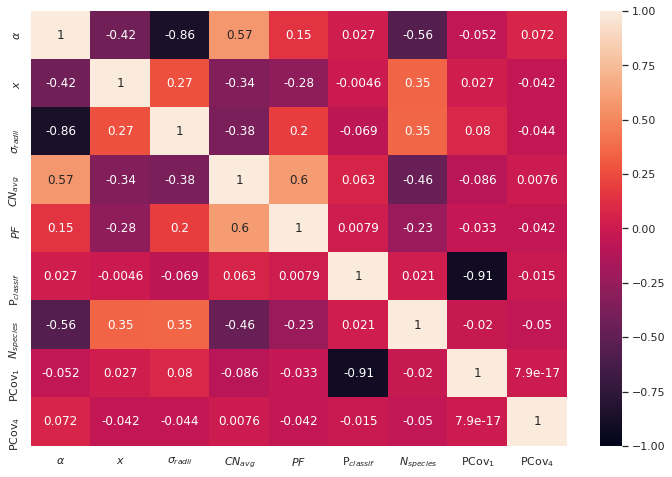

In [52]:
npzfile = np.load(path_to_geometric, allow_pickle=True)
for k in npzfile.files:
    print(k)
magic=npzfile['magic']
natoms=npzfile['natoms']
std_ratio=npzfile['std_ratio']
n_species=npzfile['n_species']
alpha=npzfile['alpha']
x=npzfile['x']
cn=npzfile['cn']
packing=npzfile['packing']
fcc=npzfile['fcc']
hcp=npzfile['hcp']

fig, axes = plt.subplots(figsize=(12,8))
dict_corr={r'$\alpha$':alpha,r'$x$':x, r'$\sigma_{radii}$':std_ratio,
    r'$CN_{avg}$':cn, r'$PF$':packing,r'P$_{classif}$':p_random_for[:,1],
      r'$N_{species}$': n_species,r'PCov$_{1}$': T[:,0], r'PCov$_{4}$': T[:,3]}
df_corr= pd.DataFrame(dict_corr)
sns.heatmap(df_corr.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

CHEMISCOPE JSON FILE TO UPLOAD ON https://chemiscope.org/

In [54]:
data = write_input(
    path='generated_chemiscope_3dcd',
    meta={"name": 'PCovR'},
    frames=my_frames,
    properties={
        **{f"PCoV_{i+1}": 
            {"target": "structure", 
            "values": T[:, i]} for i in range(n_PC)},
        "magic": {
            "target": "structure",
            "values": magic,
        }, 
         "packing": {
            "target": "structure",
            "values": packing, 
         },
         "CN": {
            "target": "structure",
            "values": cn, 
         },
        "alpha": {
            "target": "structure",
            "values": alpha, 
         },
        "x": {
            "target": "structure",
            "values": x, 
         },
        "std_rad": {
            "target": "structure",
            "values": std_ratio, 
         },
        "FCC": {
            "target": "structure",
            "values": fcc, 
         },
         "HCP": {
            "target": "structure",
            "values": hcp, 
         },
        "natoms": {
            "target": "structure",
            "values": natoms, 
         },
         
         "n_species": {
            "target": "structure",
            "values": n_species, 
         },
          "magic probability": {
            "target": "structure",
            "values": p_random_for[:,1], 
         },
    })


MP data analysis

idx
my_frames
magic
X_raw
coeff


/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


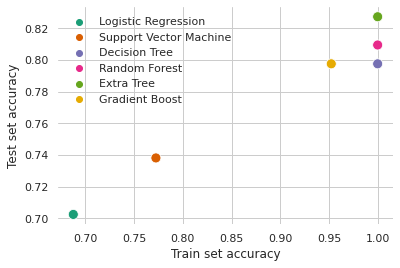

No handles with labels found to put in legend.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Classification models: ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Extra Tree', 'Gradient Boost']Train accuracies: [0.6875, 0.7723214285714286, 1.0, 1.0, 1.0, 0.9523809523809523]Test accuracies: [0.7023809523809523, 0.7380952380952381, 0.7976190476190477, 0.8095238095238095, 0.8273809523809523, 0.7976190476190477]
Accuracy on test set:0.8095238095238095
(672, 2000) (168, 2000) (672, 1) (168, 1)
[[ -5.20794147]
 [ 10.30584208]
 [  6.01352074]
 ...
 [-13.45998345]
 [  0.71092122]
 [  1.4591892 ]] [0.50290186 0.10650287 0.06248088 0.05812777 0.02811763]


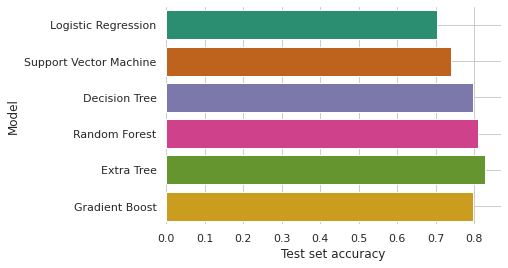

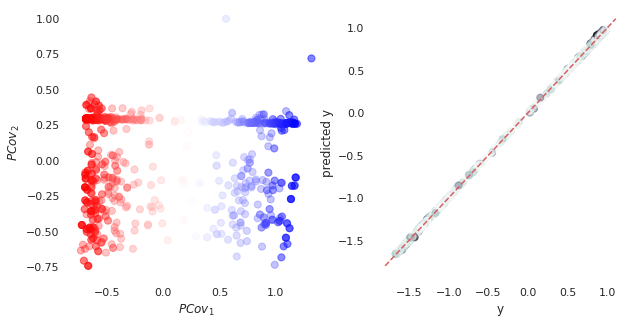

In [9]:
npzfile = np.load(DATA_MP.soap_red, allow_pickle=True)
for k in npzfile.files:
    print(k)
my_frames=npzfile['my_frames']
idx=npzfile['idx']
magic=npzfile['magic']
X_raw=npzfile['X_raw']
coeff=npzfile['coeff']

magic=[int(i) for i in magic]
magic=np.array(magic).reshape(-1,1)
y_magic=np.copy(magic.reshape(-1,1).ravel())

comp_classif(X_raw,y_magic) # prints out test set accuracy on all models

X=np.copy(X_raw)
y_magic=np.copy(magic.reshape(-1,1))

i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
np.arange(X.shape[0]), X, y_magic, train_size=0.8
)
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
# Center total dataset
X = x_scaler.transform(X)
# Center training data
X_train = x_scaler.transform(X_train)
# Center training data
X_test = x_scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

clf = RandomForestClassifier(n_estimators=100, random_state=2)
clf.fit(X_train, y_train)
clf.predict(X_test)
print('Accuracy on test set:'+str(clf.score(X_test, y_test)))
p_random_for=clf.predict_proba(X)

n_PC=5

y_tot=p_random_for[:,1].reshape(-1,1)
i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
np.arange(X.shape[0]), X, y_tot, train_size=0.8
)

x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
y_scaler = StandardFlexibleScaler(column_wise=True).fit(y_tot)

# Center total dataset
X = x_scaler.transform(X)
Y = y_scaler.transform(y_tot)

# Center training data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train)

# Center training data
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

pcovr = PCovR(mixing=0.5,
              n_components=n_PC)
pcovr.fit(X,Y)
T = pcovr.transform(X)
yp = pcovr.predict(X)
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))

ax1.scatter(T[:, 0], T[:, 1], s=50, alpha=0.3, c=p_random_for[:,1], cmap = 'bwr')
ax1.set_xlabel(r"$PCov_1$")
ax1.set_ylabel(r"$PCov_2$")
# ax1.set_xlim(-200,300)
# ax1.set_ylim(-200,400)

ax2.scatter(Y, yp, s=50, alpha=0.5, c=np.abs(Y - yp), cmap='bone_r')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'r--')
ax2.set_xlabel(r"y")
ax2.set_ylabel(r"predicted y")
sns.despine(left=True, bottom=True)

w_i_l=pcovr.pxt_
w_l_i=pcovr.pty_
w_i_p=pcovr.pxy_
var=pcovr.explained_variance_ 
sing=pcovr.singular_values_

print(w_i_p, var)

In [ ]:
data = write_input(
    path='generated_chemiscope_MP',
    meta={"name": 'PCovR'},
    frames=my_frames,
    properties={
        **{f"PCoV_{i+1}": 
            {"target": "structure", 
            "values": T[:, i]} for i in range(n_PC)},
        "magic": {
            "target": "structure",
            "values": magic,
        }, 
         "packing": {
            "target": "structure",
            "values": packing, 
         },
         "CN": {
            "target": "structure",
            "values": cn, 
         },
        "alpha": {
            "target": "structure",
            "values": alpha, 
         },
        "x": {
            "target": "structure",
            "values": x, 
         },
        "std_rad": {
            "target": "structure",
            "values": std_ratio, 
         },
        "FCC": {
            "target": "structure",
            "values": fcc, 
         },
         "HCP": {
            "target": "structure",
            "values": hcp, 
         },
        "natoms": {
            "target": "structure",
            "values": natoms, 
         },
         
         "n_species": {
            "target": "structure",
            "values": n_species, 
         },
          "magic probability": {
            "target": "structure",
            "values": p_random_for[:,1], 
         },
    })
